# Progetto DL24: YesWeKAN - Introduzione alle KAN

💡 Durante il periodo di scelta del progetto del corso di Deep Learning, il nostro collega Giovanni Zedda ci presenta un paper che si è subito sembrato interessante: [KAN: Kolmogorov–Arnold Networks](https://arxiv.org/pdf/2404.19756). Parla di una rete neurale con un concetto completamente diverso dalla classica architettura MLP, non ha una matrice di pesi con cui fare combinazioni lineari, ma ha una **matrice di funzioni**, di cui si addestrano i coefficienti.

🏅 I risultati del paper sembrano promettenti: in conclusione le reti KAN, nei loro esperimenti e con la loro implementazione, sono **più accurate**, **più spiegabili** e **più piccole** delle reti MLP, a discapito di un **addestramento più lento**, così abbiamo scelto per il nostro progetto di approfondire l'argomento.

In questo notebook vedremo come funzionano le KAN e la loro implementazione, per poi spostarci nel codice dove faremo un esempio di utilizzo delle KAN.

### Importazione delle librerie e configurazione random seed

📚 Per prima cosa, importiamo qui tutte le librerie che ci saranno utili in questo notebook

⚠️ Per rendere l'esperimento ripetibile, andiamo anche ad **impostare il seme casuale** di tutte le librerie che contengono un fattore di casualità, in modo che queste vadano a **generare gli stessi valori** sequenzialmente ad ogni riavvio del notebook (o meglio, del kernel Python che esegue il notebook).

Ci teniamo a far notare che in questo modo, nel caso si esegua più volte la stessa cella, essa probabilmente non presenterà gli stessi risultati, andando a **compromettere la riproducibilità** di tutte le celle di codice a seguire. Per riportare il flusso di esecuzione ad uno stato di riproducibilità sarà necessario **riavviare il kernel** Python del notebook.

La scelta di impostare il _seed_ e non ogni volta il _random state_ è dovuta al fatto che per alcune librerie risultava difficoltoso se non impossibile impostare ogni random state, oltre ad un fattore di comodità maggiore ed un fattore di rischio minore nella scrittura del codice. Il _seed_ viene impostato prima di importare le librerie custom del progetto poiché fare il contrario non garantiva la riproducibilità.

In [1]:
# Librerie di sistema
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt

# Impostazione dei semi casuali
seed_value = 0
os.environ['PYTHONHASHSEED'] = str(seed_value)
tf.keras.utils.set_random_seed(seed_value)

# Librerie custom
import utility as ut
from tfkan import DenseKAN, Spline

# Cosa sono le KAN

📋 Prima di partire con l'implementazione dei modelli e quindi delle KAN, dobbiamo capire come funzionano e quali sono le caratteristiche fondamentali di queste. Per fare ciò la comprensione del paper da cui abbiamo preso ispirazione per il progetto ci ha dato una grossa mano, e qui riportiamo i punti salienti.

📈 Le **Kolmogorov Arnold Network** (KAN) sono un'alternativa alle reti multi-layer perceptron (MLP). Mentre le MLP hanno le funzioni di attivazione fissate sui nodi e utilizzano pesi lineari, le KAN hanno le funzioni di **attivazione non lineari addestrabili sugli archi**, e usano parametri definiti come funzioni univariate, spesso **funzioni spline**. I neuroni semplicemente sommano i risultati degli archi entranti.

➕ Mentre le MLP sono ispirate al Teorema dell'Approssimazione Universale, le KAN sono ispirate al **Teorema di Rappresentazione di Kolmogorov-Arnold**, il quale afferma che qualsiasi funzione continua multivariata può essere rappresentata come somma di funzioni di una sola variabile e un numero finito di funzioni.

📊 Le KAN possono essere visualizzate in modo intuitivo, poiché le funzioni di attivazione sugli archi sono **facilmente interpretabili e analizzabili**. Questo aspetto le rende più interpretabili e spiegabili, anche se a parità di parametri sono **più costose da addestrare** e memorizzare rispetto alle MLP. Tuttavia, le KAN più piccole possono essere **più accurate e efficienti** nei parametri.

## Spline

🔂 Una spline è una funzione composta da **segmenti polinomiali** definiti su intervalli diversi, che si uniscono in modo liscio. Ciò significa che i polinomi che formano la spline si connettono in punti specifici chiamati nodi, garantendo **continuità e derivate continue** fino a un certo ordine. Le spine di un ordine $n$ si definiscono ricorsivamente da quelle di ordine $0$.

♒ Data una funzione, un numero di intervalli e il grado, le spline **approssimano tale funzione**, come si vede nell'immagine di sinistra. 

🔎 È possibile aumentare il numero di intervalli, quindi aumentando la precisione dell'approssimazione globalmente, come si vede nell'immagine centrale, ed è possibile aumentare il loro grado per aumentare la precisione dell'approssimazione localmente (spline di grado 0 approssimeranno la funzione con delle rette orizzontali, spline di grado 1 con rette oblique, di grado 2 con parabole, ecc...), come si vede nell'immagine d destra.

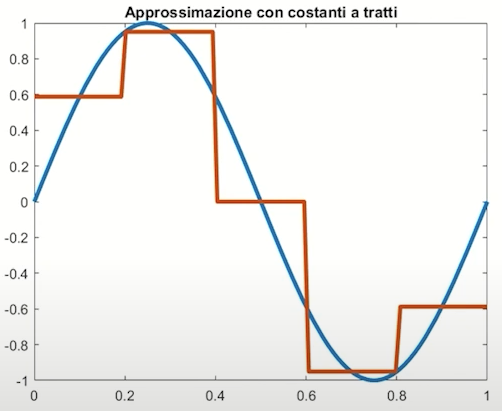 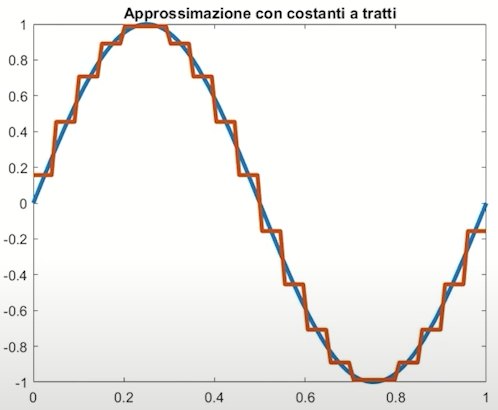 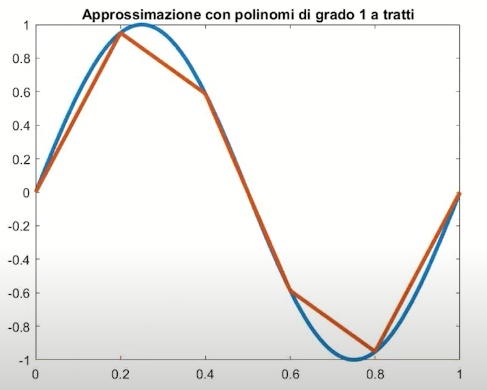

## Accuratezza

🎭 Le KAN sanno essere più accurate delle MLP. Le spline offrono un **maggiore potere espressivo**, espressività che le MLP per raggiungerlo devono essere molto più grandi e complesse.

🏅 Le KAN grazie a questo raggiungono la stessa accuratezza delle MLP addestrandosi con **molti meno parametri** (quindi una rete molto più compatta), ma **più complicati da addestrare** (che richiedono più tempo a causa della maggior complessità nella fase di fowardpass e backpropagation, dovuta alla definizione ricorsiva delle spline). La maggiore espressività porta però le KAN ad essere **più scalabili**, quindi ad aumentare la propria accuratezza più velocemente delle MLP, e questo porta ad avere prestazioni migliori su un **numero di epoche minore** delle MLP; il confronto quindi sarà tra una rete KAN con un maggiore tempo di addestramento per epoca contro una rete MLP con un maggior numero di epoche, in cui la rete KAN è più scalabile.

⚡ Nel confronto dobbiamo però anche considerare che le reti KAN, venendo studiate in questo momento, **non sono ottimizzate** tanto quanto le reti MLP, e questo sicuramente porta ad uno svantaggio competitivo nei confronti tra le due.

## Interpretabilità

🧮 Le KAN riescono ad essere più interpretabili per loro natura. Il teorema di Kolmogorov-Arnold, su cui sono basate, offre una **struttura matematica chiara** per essere visualizzata e capita. Inoltre la capacità di poter visualizzare le funzioni di attivazione direttamente nell'arco permette una più facile interpretabilità rispetto all'architettura MLP.

✖️ Le KAN inoltre, attraverso le spline, riescono ad **imparare funzioni comuni** facilmente, come moltiplicazione, divisione, e simili. Grazie a questo, le KAN durante l'addestramento possono ottenere alcune delle funzioni spline addestrabili che approssimano sempre di più una funzione nota (quale ad esempio una funzione esponenziale). È dunque possibile impostare i coefficienti di tale spline direttamente per approssimare il più fedelmente possibile tale funzione e controllare le sue performance. Nel caso in cui queste migliorino, si è trovato una funzione simbolica per quell'arco. Quando questo avviene su tutti gli archi attivi della rete (se il datatset lo concede), si è arrivati ad **avere la formula simbolica** per eseguire il task algoritmicamente. Questo è un concetto molto utile quando si sospetta che il valore della label derivi da diverse operazioni svolte sui valori degli attributi, ma non si conoscono queste operazioni; le reti KAN offrono un ambiente con cui ricercare intuitivamente questa formula simbolica sconosciuta a priori.

# Implementazione delle KAN

## Implementazione del paper

Il paper descrive precisamente come il gruppo di lavoro ha operato per implementare l'architettura KAN, che è formata da uno o più livelli, che chiameremo **_DenseKAN_**.

❇️ Ogni livello _DenseKAN_, come il livello _Dense_ classico, ha tanti archi quanti il prodotto del numero di input per il numero di output. Ogni arco computa una **funzione di attivazione $\phi$**, che è formata da una spline, con i suoi coefficienti $c_i$. La spline è quindi calcolata come una combinazione lineare tra i coefficienti e le funzioni B-Spline del grado voluto:

$$
spline(x) = \sum_i{c_iB_i(x)}
$$

➕ Per ogni arco il risultato della spline è poi moltiplicato per un **fattore di scala** $w_s$, e quindi sommato ad un **termine di bias**, che comprende un coefficiente $w_b$ moltiplicato per una funzione $b(x)$:

$$
\phi(x) = w_bb(x) + w_sspline(x)
$$

⏬ Questa funzione $b$, chiamata _basis function_ dal paper, è simile ad una **connesione residua**, ed è stata definita dal paper uguale alla funzione $silu(x)$.

🔡 Dato che ogni arco del livello ha la propria funzione $\phi$, è possibile formalizzare un livello _DenseKAN_ con $n$ input e $m$ output come una matrice $\Phi$ di funzioni di attivazione:

$$
\Phi = 
\begin{pmatrix}
\phi_{1,1} & \phi_{1,2} & \cdots & \phi_{1,n} \\
\phi_{2,1} & \phi_{2,2} & \cdots & \phi_{2,n} \\
\vdots & \vdots & \ddots & \vdots \\
\phi_{m,1} & \phi_{m,2} & \cdots & \phi_{m,n}
\end{pmatrix}
$$

🔀 Tutte le funzioni nella forma $\phi_{\cdot, i}$ prendono come argomento lo stesso input $x_i$, mentre tutti i risultati delle funzioni nella forma $\phi_{j, \cdot}$ confluiscono nello stesso neurone $j$. Possiamo quindi dire che il j_esimo output viene calcolato con la formula:

$$
\sum_{i_{0}=1}^{m}\phi_{n,i_0}(x_{i_0})
$$

### Dettagli implementativi

📍 Gli autori del paper hanno definito anche come inizializzare i diversi pesi: i coefficienti delle spline seguono una distribuzione normale $c_i∼N(0, 0.1)$, in modo che $spline(x)≈0$, i fattori di scala $w_s$ vengono inizializzati tutti a 1, mentre i coefficienti del bias $w_b$ seguono un'inizializzazione Glorot.

💱 Le MLP, una volta addestrate, nel caso si voglia rendere la rete più complessa, si devono riaddestrare da capo; Le KAN invece hanno la particolarità che, una volta addestrate, basta **rendere l'intervallo delle spline più piccolo** espandendo quindi la così detta griglia, migliorando così l'approssimazione della distribuzione dell'input, per aumentare il suo numero di parametri e così la sua complessità e la sua accuratezza. Quando si aumenta il numero degli intervalli, è possibile calcolare il valore dei nuovi coefficienti a partire dai precedenti, in modo da **non perdere i progressi** fatti fino a quel punto.

💁‍♂️ Per aumentarne l'interpretabilità, il paper definisce 4 passaggi che semplificano le reti KAN:
- **Sparsificazione**: se nelle reti MLP viene usata una regolarizzazione L1 nei pesi lineari, un simile concetto può essere applicato anche alle reti KAN. Per farlo però c'è bisogno di definire la norma L1 sulle funzioni di attivazione $\phi$, e poi in aggiunta una definizione della funzione di entropia sempre sulle funzioni di attivazione, poiché la sola norma L1 non bastava. La somma pesata delle due, moltiplicata per un fattore di controllo, fa da regolarizzatore.
- **Visualizzazione**: una volta addestrata la rete, è possibile visualizzare le funzioni di attivazione di ogni arco, impostando per ognuna una diversa opacità a seconda di quanto una funzione influisca sul risultato totale del neurone.
- **Potatura**: è possibile definire per ogni neurone un punteggio in entrata e in uscita, in base a quanto il risultato di quel nodo impatti sul risultato del livello successivo; in questo modo è possibile classificare i nodi per importanza, e quindi potare i nodi meno importanti.
- **Simbolificazione**: nel caso in cui si crede che la funzione di attivazione sia uguale a una funzione simbolica riconosciuta, è possibile impostare manualmente i coefficienti della funzione di attivazione in modo che essa approssimi la funzione simbolica.

## Implementazione nel nostro progetto

🌐 Gli autori del paper sopra citato hanno implementato i loro modelli e li hanno [messi a disposizione](https://github.com/KindXiaoming/pykan), ma li hanno scritti usando il framework di PyTorch; data la differenza rispetto a Tensorflow che abbiamo usato durante il corso, abbiamo scelto di **implementare un livello _DenseKAN_ autonomamente** sul framework di Tensorflow, anche per prendere confidenza con i concetti che ci sono dietro e che analizzeremo a breve. Fortunatamente non siamo partiti completamente da zero, abbiamo infatti trovato la libreria [tfkan](https://github.com/ZPZhou-lab/tfkan), che sembra implementi i concetti che ci interessano su Tensorflow, basandosi proprio sullo stesso paper.

### DenseKAN

🏚️ Nella realtà però, dopo averla provata, ci siamo resi conto che **non era funzionante**, probabilmente a causa del fatto che sembra sia stata scritta per un ambiente obsoleto. La abbiamo così **analizzata e rinnovata**. Dopo aver corretto qualche iniziale bug di esecuzione generale e aver reso funzionanti i requisiti minimi per una corretta esecuzione, abbiamo effettuato una scrematura su che cosa ci sarebbe servito e cosa no.

⛓️ La libreria implementava anche la **funzione di estensione della griglia**, ma dopo esserci informati, nelle più recenti versioni di Tensorflow, una volta fatto il build del modello, non si può più cambiare il suo numero di pesi, e anche con versioni più obsolete ci saremmo riusciti soltanto sfruttando qualche mancato controllo del framework di Tensorflow. A causa di ciò, abbiamo preferito non usare un framework obsoleto sfruttando alcuni escamotage per aggirare i suoi controlli; abbiamo optato per rendere il nostro progetto funzionante nelle più recenti versioni di tutte le librerie utilizzate, **senza per cui implementare questa funzionalità**, nonostante sarebbe stata una tra le più interessanti da studiare.

⏭️ Ci siamo poi concentrati sulla **semplificazione e l'ottimizzazione**, e nel farlo abbiamo inserito diversi commenti non solo per aiutarci nella comprensione del codice stesso, ma anche e soprattutto per chi leggerà il codice dopo di noi. Vista anche la portata del progetto, abbiamo **evitato di implementare** anche la norma L1, l'entropia e la regolarizzazione dei pesi come le ha definite il paper, non solo per non rendere il nostro progetto troppo macchinoso dal punto di vista matematico, ma anche per esplorare le prestazioni dell'architettura KAN non del tutto analizzate dal paper. Abbiamo invece impostato di default gli inizializzatori suggeriti dagli autori. Abbiamo quindi lavorato per rendere i livelli _DenseKAN_ i più simili possibili ad un livello _Dense_ di tipo MLP, andandoci a vedere il codice sorgente di Keras.

Abbiamo scelto di non inserire l'implementazione dei livelli _DenseKAN_ nei notebook, ma di tenerla in un file Python a parte, questo in modo che potesse venire importata da tutti i notebook che devono usarla. La si può trovare nella cartella `tfkan` nel file `dense.py`

### Spline

📉 La libreria aveva già di suo una funzione per calcolare la spline dati tutti i suoi parametri. Da quella, che abbiamo modificato per avere al suo interno tutte le operazioni effettuate dalla funzione di attivazione dell'arco, abbiamo sviluppato una **classe `Spline`**. Questo per rispondere al nostro bisogno di ottenere la funzione di attivazione di ogni arco nel livello `DenseKAN`, in modo che con queste potessimo costruire i suoi grafici.

📞 Questa classe prende in input tutti i parametri delle funzioni di attivazione, e sfrutta il metodo `__call__` per restituire i risultati delle spline dato un input alla chiamata.

La classe `Spline` e la funzione `spline`, che svolge effettivamente tutti i calcoli necessari al risultato delle spline, si trovano nella cartella `tfkan` nel file `spline.py`.

### Verifica delle operazioni

🔎 Dopo aver implementato le spline, siamo passati ad una fase di verifica di queste, in modo che potessimo essere certi della correttezza delle operazioni che andiamo a svolgere. Per farlo, possiamo sfruttare la classe `BSpline` della libreria `scipy`, che offre le stesse operazioni, ma che non abbiamo potuto sfruttare nella nostra libreria, in quanto non supporta i tensori simbolici che Tensorflow sfrutta durante l'addestramento, che vengono invece supportati dalla nostra implementazione.

🟰 Per verificare la correttezza delle operazioni, ci basta creare un'istanza della classe `BSpline`, e un'istanza della nostra classe `Spline`, entrambe con gli stessi parametri, ma facendo in modo che la nostra classe non effettui le altre operazioni che le funzioni di attivazione di _DenseKAN_ svolgono, quali la moltiplicazione per il fattore di scala, e la somma con un termine di bias. Controllando che l'output di entrambe sia lo stesso, possiamo verificare la correttezza dei calcoli della classe `Spline`

In [2]:
# Istanziamo gli oggetti BSpline e Spline
knots = np.linspace(-4, 4, 9)
correct_spline = BSpline(knots, [4, 1, 2, 5, 3], 3, extrapolate=False)
my_spline = Spline(knots, [4, 1, 2, 5, 3], 3, ws=1, b=None, wb=0, dtype=tf.float64)

# Creiamo un array randomico di 10 numeri
array = np.random.uniform(0, 1, size=10)

# Stampiamo i risultati
print("Original array: ")
print(array)
print()
print("Spline of scipy: ")
print(correct_spline(array))
print("Our spline: ")
print(my_spline(array).numpy())


Original array: 
[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548  0.64589411
 0.43758721 0.891773   0.96366276 0.38344152]

Spline of scipy: 
[3.53930593 3.84842212 3.64668586 3.5312604  3.27141416 3.72793824
 3.30223495 4.08474941 4.14525304 3.18147129]
Our spline: 
[3.53930593 3.84842212 3.64668586 3.5312604  3.27141416 3.72793824
 3.30223495 4.08474941 4.14525304 3.18147129]


✅ Come possiamo vedere, i risultati degli array fatti passare per le spline sono gli stessi, per cui stiamo svolgendo le spline correttamente.

❗ Ci teniamo a far notare che le spline per poter essere calcolate hanno bisogno che venga rispettata una condizione: che il numero di nodi meno l'ordine meno 1, sia minore o uguale al numero di coefficienti e maggiore o uguale all'ordine più 1. In formula: $|c|>=|t|-k-1>=k+1$, doce $c$ sono i coefficienti e $t$ i nodi.

⚠️ Inoltre avvertiamo come l'implementazione di `scipy` delle spline differisce leggermente per alcuni dettagli, a causa dei quali dobbiamo inserire il parametro `extrapolate=False`, che però nella loro implementazione riduce il dominio in cui sono definite le spline, mentre nella nostra implementazione questo non succede; a causa di ciò, modificando i parametri potrebbe non essere raro imbattersi in valori `nan` come risultato della classe `BSpline`.

# Esempio di rete KAN

🧠 Ora ci spostiamo nella parte di codice, in cui vedremo come **utilizzare un modello** con i livelli _DenseKAN_, lo addestreremo, e andremo a **visualizzare le spline** create per ogni suo arco e come queste agiscono in fase di predizione.

## Preparazione del dataset

Per questo esempio utilizzeremo i dataset già separati in training e test, che vengono creati dal notebook **Analisi confronto e interpretabilità**, salvati nella cartella `datasets`. Dopo averli caricati dai file, scegliamo un record casualmente da far predirre alla rete dopo il suo addestramento.

In [3]:
# Caricamento del dataset
x_train = pd.read_csv("datasets/x_train.csv")
y_train = pd.read_csv("datasets/y_train.csv")
x_test = pd.read_csv("datasets/x_test.csv")
y_test = pd.read_csv("datasets/y_test.csv")

# Conversione in tensori
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Stampa delle dimensioni per una verifica della corretta esecuzione
print("Training set:", "X =", x_train.shape, "y =", y_train.shape)
print("Test set:", "X =", x_test.shape, "y =", y_test.shape)

# Selezione record di esempio
RECORD_NUMBER = np.random.randint(0, x_test.shape[0]-1)
my_record = x_test[RECORD_NUMBER]
my_label = float(y_test[RECORD_NUMBER])
print("My record number:", RECORD_NUMBER)

Training set: X = (80000, 25) y = (80000, 1)
Test set: X = (20000, 25) y = (20000, 1)
My record number: 18983


## Addestramento della rete KAN

A questo punto possiamo definire l'architettura del modello, compilarlo ed addestrarlo. Faremo un breve addestramento, con parametri non ottimi, in quanto in questo notebook l'obiettivo non è quello di ottimizzare le prestazioni, ma piuttosto quello di illustrare il processo. Impostiamo semplicemente `grid_range=(-2, 2)` nell'ultimo livello, per avere delle spline che approssimino la distribuzione dell'input (ovvero l'output del primo livello) anche se questo dovesse avere dei valori in quell'intervallo.

Impostiamo un numero massimo di epoche di 50, ma configuriamo una callback di early stopping per fermare l'addestramento anche nel caso in cui non dovesse migliorare il suo miglior risultato per 5 epoche consecutive.

In [4]:
# Definizione variabili di supporto
input_dim = x_train.shape[1]
layer1_dim = 4
layer2_dim = 1

# Callback per l'addestramento
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

# Architettura del modello
model = tf.keras.models.Sequential([
    DenseKAN(layer1_dim),
    DenseKAN(layer2_dim, grid_range=(-2, 2))
])

# Costruzione, compilazione e addestramento del modello
model.build(input_shape=(None, input_dim))
model.summary()
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.002), loss='mae', metrics=['mae', 'mse'])
model.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=callbacks)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan (DenseKAN)            │ (None, 4)              │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_1 (DenseKAN)          │ (None, 1)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 624 (2.44 KB)

 Trainable params: 624 (2.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.2917 - mae: 1.2917 - mse: 3.4672 - val_loss: 0.6196 - val_mae: 0.6196 - val_mse: 0.7984
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6145 - mae: 0.6145 - mse: 0.7568 - val_loss: 0.5715 - val_mae: 0.5715 - val_mse: 0.6745
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5789 - mae: 0.5789 - mse: 0.6833 - val_loss: 0.5526 - val_mae: 0.5526 - val_mse: 0.6432
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5593 - mae: 0.5593 - mse: 0.6518 - val_loss: 0.5410 - val_mae: 0.5410 - val_mse: 0.5968
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5442 - mae: 0.5442 - mse: 0.6283 - val_loss: 0.5305 - val_mae: 0.5305 - val_mse: 0.5861
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5322 - mae: 0.5322 - mse: 0.6113 - val_loss: 0.5303 - val_mae: 0.5303 - val_mse: 0.5780
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5224 - mae: 0.5224 - mse

## Visualizzazione delle spline

Ora che abbiamo addestrato il modello, possiamo chiedere ad esso di predirre la label del nostro record scelto casualmente. Ma è interessante andare a vedere più da vicino quali sono le operazioni che svolge il modello in fase di predizione, in particolare andando a visualizzare le funzioni di attivazione nei suoi archi. Per farlo, estraiamo le spline del layer con il metodo `get_spline_list()`. Questo metodo restituisce la matrice delle spline di dimensione `input_dim*output_dim`, ovvero $m*n$.

Per la rappresentazione grafica delle spline, strutturiamo una funzione che crei una matrice grafica $n*m$, con un grafico di spline in ogni cella; ogni spline nella colonna $i$ prenderà in input $x_i$, ovvero l'i-esimo attributo del record d'esempio (qui segnato con una linea rossa), infatti si può notare come le linee rosse siano allineate verticalmente; ogni spline restituirà in output l'immagine dell'attributo che riceve in input (qui segnato con una linea verde).

Il vettore passato al livello successivo, di dimensione $n$, avrà come j-esimo valore la somma delle immagini rappresentate nella riga $j$ del livello precedente. In questa cella calcoliamo per ognuna delle $j$ unità in output dal livello $L_k$ $$L_{k,j} = \sum_{i=1}^{m}{\phi_{j,i}(x_i)}$$

Avremo infine gli $n$ valori restituiti dal livello.

In [5]:
def visualize_spline(spline_list, record):
    # Estrazione dimensioni
    in_dim = len(spline_list)
    out_dim = len(spline_list[0])

    # Preparazione dell'area grafica  
    fig, axes = plt.subplots(out_dim, in_dim, figsize=(30, 10))

    # Variabile su cui salvare l'output del layer
    layer_output = np.zeros(out_dim)

    # Stampa delle spline per ogni cella
    for i in range(out_dim):
        for j in range(in_dim):
            # Nasconde i tick degli assi
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])

            # Grafico della spline
            xx = np.linspace(-2, 2, 100)
            yy = spline_list[j][i](xx)
            axes[i][j].plot(xx, yy)

            # Linee dell'attributo e della sua immagine
            axes[i][j].axvline(x=record[j], color='red', alpha=0.6)
            axes[i][j].axhline(y=spline_list[j][i](record[j]), color='green', alpha=0.6)
            axes[i][j].plot(record[j], spline_list[j][i](record[j]), 'ro')

            # Calcolo dell'output del livello
            layer_output[i] += spline_list[j][i](record[j])
            
    return layer_output

Per il primo livello, avremo quindi una matrice di 4 righe (una per output) e 25 colonne (una per input).

Output del primo livello: [ 1.04760647  1.25105855  1.07634566 -1.48987578]


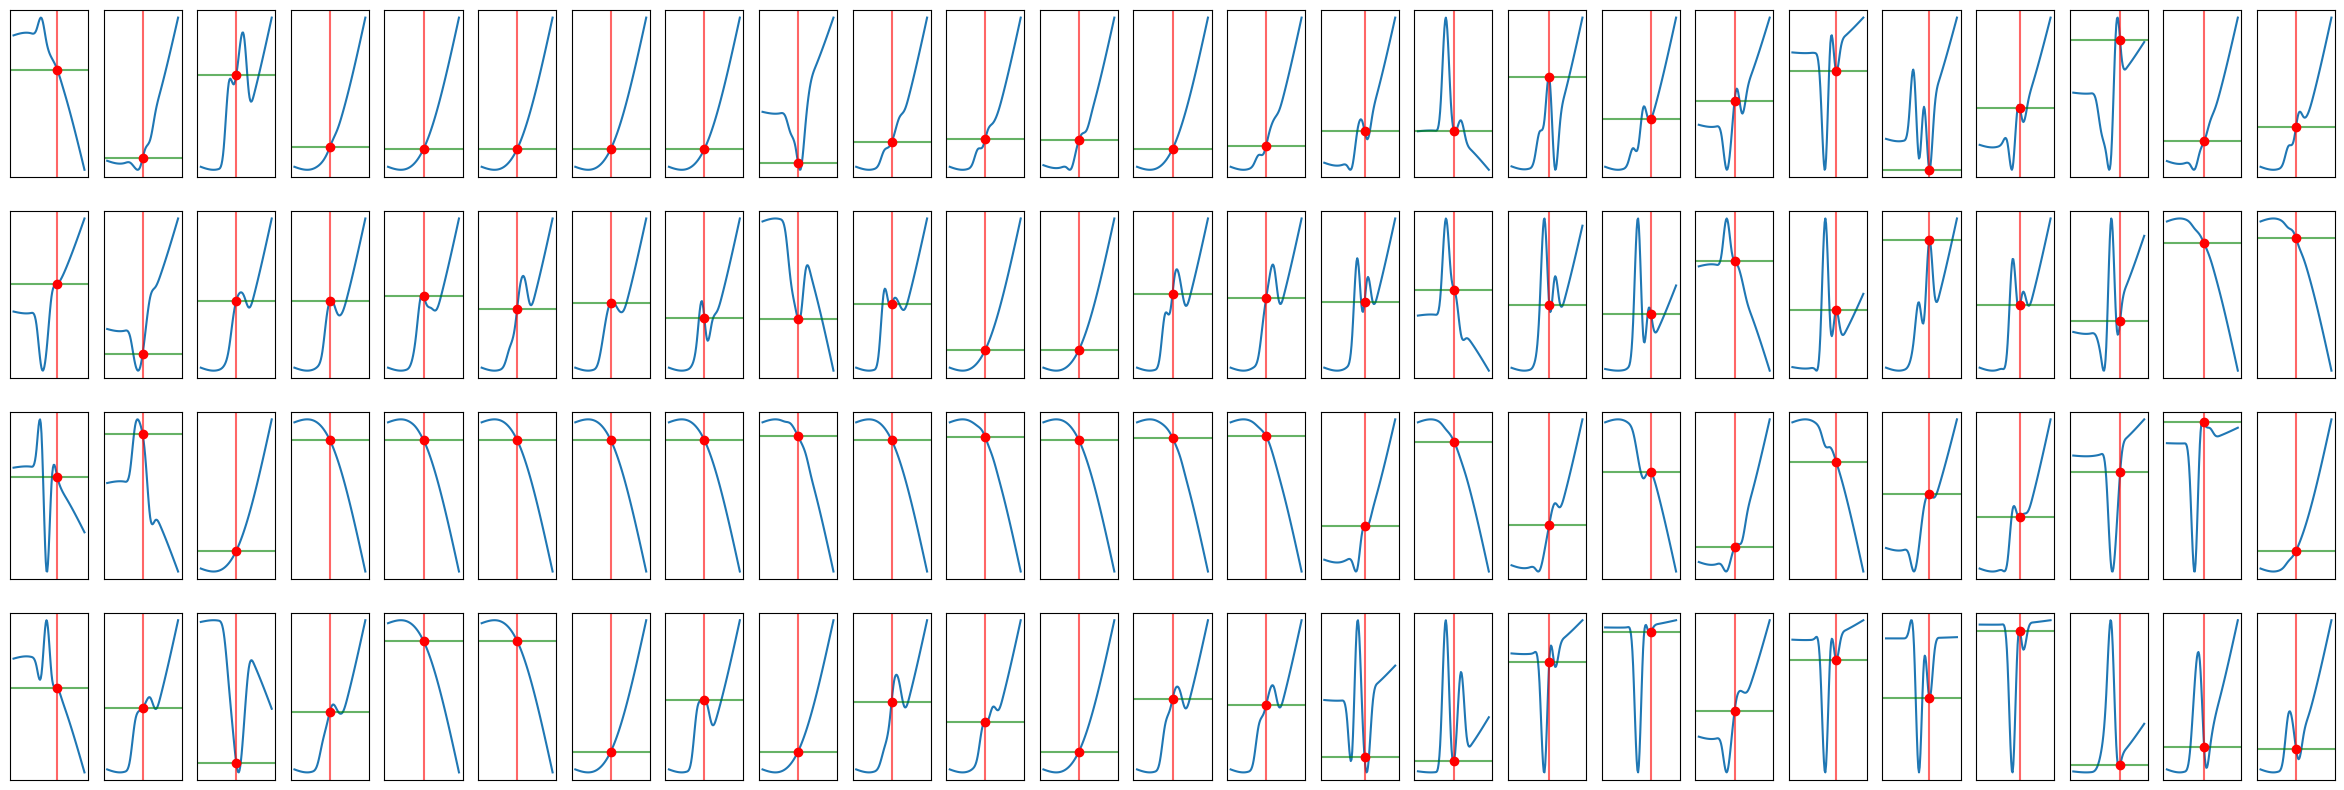

In [6]:
# Estrazione delle spline del livello
spline_list = model.layers[0].get_spline_list()

# Visualizzazione delle spline e ottenimento output del primo livello
layer1_output = visualize_spline(spline_list, my_record)

# Stampa
print(f"Output del primo livello: {layer1_output}")
plt.show()

Passando ora al secondo livello, che sarà una matrice di spline di 1 riga e 4 colonne, ripetiamo il medesimo processo e vediamo il valore che la rete restituisce in output.

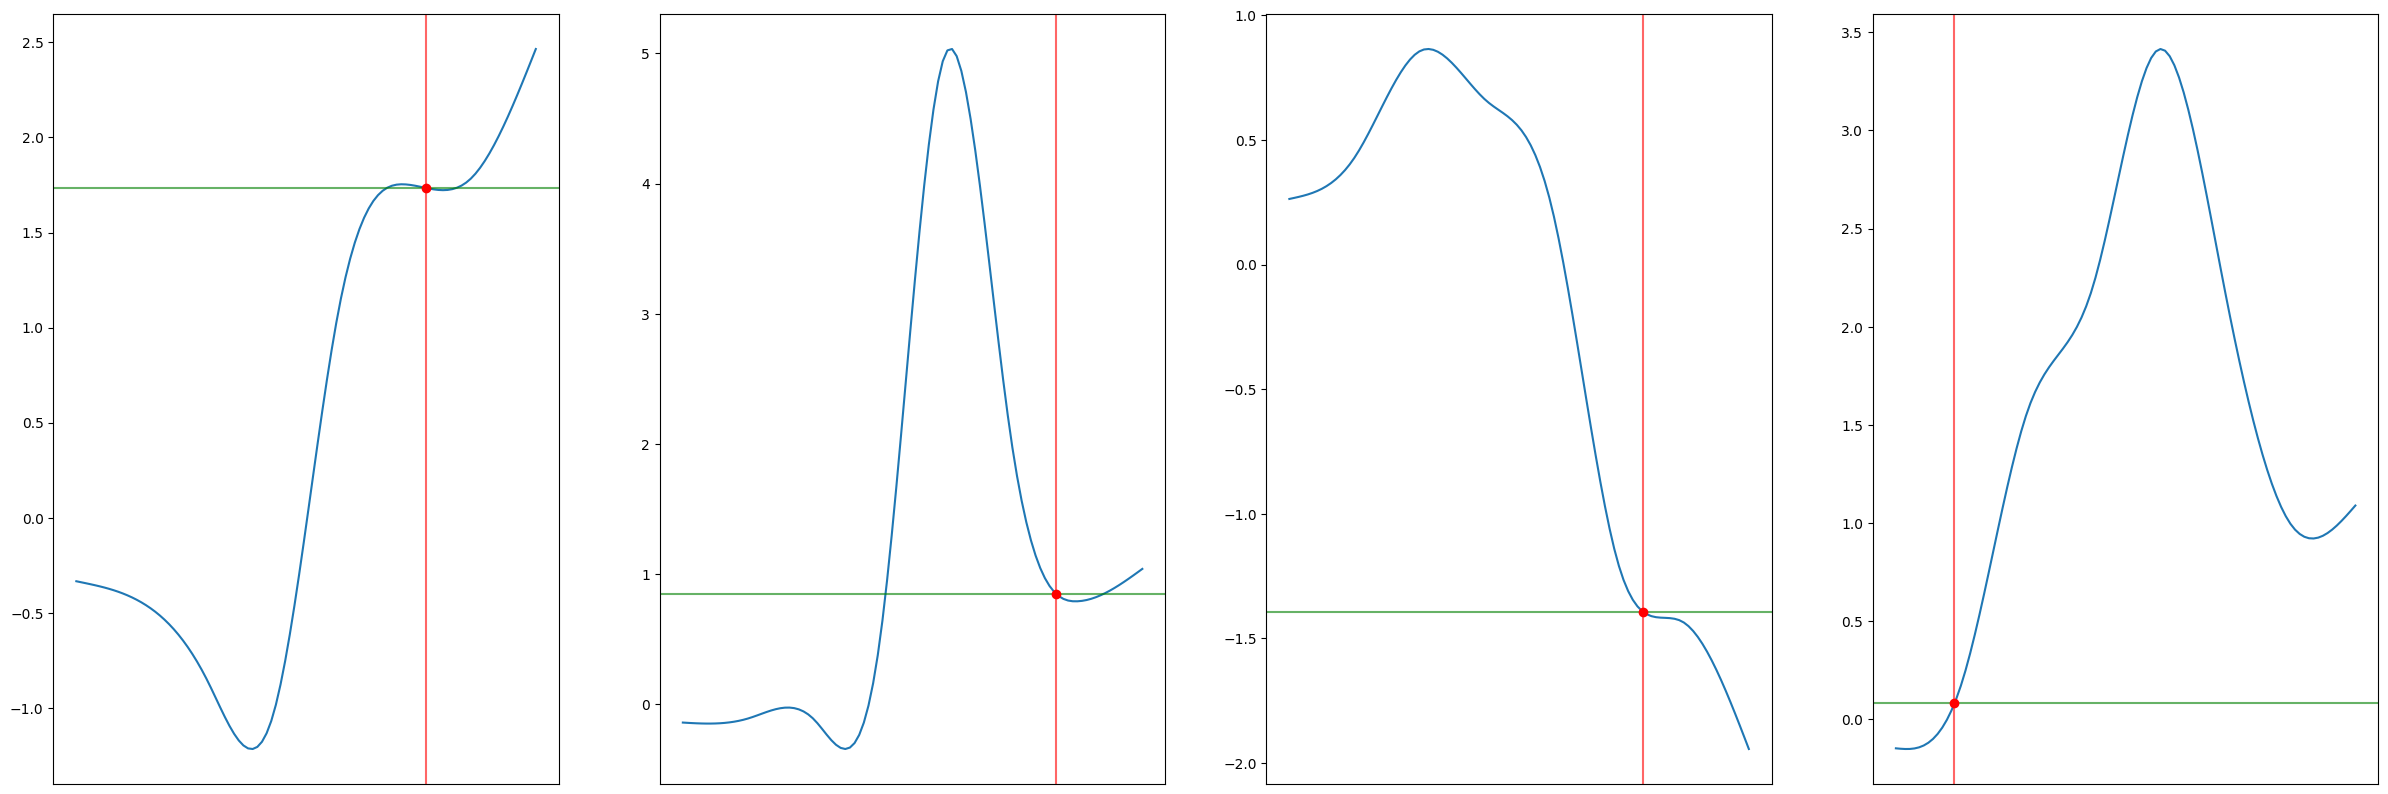

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
Predizione della rete tramine metodo "predict": 1.2700821161270142
Predizione della rete tramine le spline: 1.2700817435979843
Label reale: 1.0


C:\Users\matte\AppData\Local\Temp\ipykernel_340\1129025325.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f'Predizione della rete tramine metodo "predict": {float(model.predict(tf.reshape(my_record, (1, -1))))}')


In [7]:
fig, axes = plt.subplots(layer2_dim, layer1_dim, figsize=(30, 10), squeeze=False)

spline_list_1 = model.layers[1].get_spline_list()

layer2_output = 0

for i in range(layer2_dim):
    for j in range(layer1_dim):

        xx = np.linspace(-2, 2, 100) if -2 <= layer1_output[j] <= 2 else np.linspace(-abs(layer1_output[j]), abs(layer1_output[j]), 100)
        yy = spline_list_1[j][i](xx)
        axes[i][j].plot(xx, yy)
        axes[i][j].set_xticks([])
        axes[i][j].axvline(x=layer1_output[j], color='red', alpha=0.6)
        axes[i][j].axhline(y=spline_list_1[j][i](layer1_output[j]), color='green', alpha=0.6)
        axes[i][j].plot(layer1_output[j], spline_list_1[j][i](layer1_output[j]), 'ro')
        layer2_output += spline_list_1[j][i](layer1_output[j])

plt.show()

print(f'Predizione della rete tramine metodo "predict": {float(model.predict(tf.reshape(my_record, (1, -1))))}')
print(f"Predizione della rete tramine le spline: {layer2_output}")
print(f"Label reale: {my_label}")

✅ Come possiamo vedere, la predizione della rete tramite metodo `predict` e attraverso le spline sono equivalenti, ed entrambe sono molto spesso vicine alla label reale.